## **EXP1 Predicting Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP1 analysis and results. Files used were created in preprocessing/EXP1_pseudos notebook.*

**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

The residual is calculated in three different ways named: Residual (comparing NNLS calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
SVD, PCA, ICA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP1.py file and can be run through paperpill using run_EXP1.sh file.

In [2]:
#####################
### set the study ###
#####################
#paths:
res_name = f"MCT_snadp_EXP1"
pseudo_name = "MCT_snadp_EXP1_5CTnoise"
files_path = "/../data/EXP1/"
cibersort_files = "/../data/EXP1/cibersort/CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_phenoclasses.CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_refsample.bm.K999.txt"
noise_type = "5CTnoise"
###### set your random seed, num missing cells, and num_samples for reference for reproducibility
random_seed = 88
bulkprop_type = "random"
num_missing_cells = [0, 1, 2, 3, 4]
num_samples = 10000
#how to handle negative residual distribution for NMF
nmf_cut = "minimum_value"
kerne_name = "env_ml"

In [3]:
# Parameters
res_name = "MCT_snadp_EXP1"
pseudo_name = "MCT_snadp_EXP1_5CTnonoise"
files_path = "/data/EXP1/"
noise_type = "5CTnonoise"
cibersort_files = "/data/EXP1/cibersort/CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_phenoclasses.CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_refsample.bm.K999.txt"
random_seed = 88
num_missing_cells = [0, 1, 2, 3]
num_samples = 10000
nmf_cut = "minimum_value"
kernel_name = "env_ml"


In [4]:
#parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"

Import the previously processed datasets. 

*See preprocessing/EXP1_pseudos.ipynb notebook for details.*

In [5]:
#and as anndata object
adata_path = os.path.join(path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata

AnnData object with n_obs × n_vars = 116066 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [6]:
Counter(sn_adata.obs["cell_types"])

Counter({'mesothelial cell': 26276,
         'fat cell': 24825,
         'macrophage': 13625,
         'preadipocyte': 26941,
         'endothelial cell': 11480,
         'endothelial cell of lymphatic vessel': 2339,
         'pericyte cell': 1165,
         'T cell': 3022,
         'smooth muscle cell': 2457,
         'B cell': 231,
         'dendritic cell': 679,
         'mast cell': 883,
         'monocyte': 709,
         'stromal cell of endometrium': 284,
         'immature NK T cell': 1073,
         'neutrophil': 77})

In [7]:
#excluding all cell types except 5 of interest
if pseudo_name == "MCT_snadp_EXP1_5CTnoise" or pseudo_name == "MCT_snadp_EXP1_5CTnonoise": #if pseudos have 5 cell types
    exclude = ['preadipocyte',
        'mesothelial cell',
        'pericyte cell',
        'fat cell',
        'endothelial cell',
        'endothelial cell of lymphatic vessel',
        'smooth muscle cell',
        'mast cell',
        'immature NK T cell',
        'stromal cell of endometrium',
        'neutrophil']
    sn_adata = sn_adata[~sn_adata.obs["cell_types"].isin(exclude), :]
#Tilde is “not”, so this reads like “var names that are not in exclude”
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'macrophage': 13625, 'T cell': 3022, 'monocyte': 709, 'dendritic cell': 679, 'B cell': 231})


Randomly selecting cells to delete:

In [8]:
cells_to_miss = sn_sc_preprocess.select_cells_missing(sn_adata, num_missing_cells, random_seed)
cells_to_miss    

{0: [], 1: [2], 2: [2, 3], 3: [2, 3, 4]}

## Creating reference profiles and Importing Bulks:


1. ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). Once it is clipped and scaled with MinMax(), it becomes:
2. ref_df, which is used in NNLS. 

In [9]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var_names
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw

,macrophage,T cell,B cell,dendritic cell,monocyte
A1BG,102.0,118.0,83.0,221.0,123.0
A1BG-AS1,393.0,329.0,407.0,662.0,369.0
A1CF,13.0,25.0,0.0,33.0,0.0
A2M,10573.0,11841.0,2226.0,8314.0,2120.0
A2M-AS1,104.0,1432.0,308.0,131.0,74.0
...,...,...,...,...,...
AL049555.1,2.0,0.0,0.0,0.0,0.0
AL109945.1,0.0,0.0,0.0,0.0,0.0
HIST1H3G,0.0,0.0,0.0,33.0,13.0
PAEP,4.0,0.0,0.0,0.0,0.0


In [10]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df

,macrophage,T cell,B cell,dendritic cell,monocyte
A1BG,0.022719,0.026283,0.018487,0.049225,0.027397
A1BG-AS1,0.087537,0.073281,0.090655,0.147454,0.082191
A1CF,0.002896,0.005568,0.000000,0.007350,0.000000
A2M,1.000000,1.000000,0.495818,1.000000,0.472208
A2M-AS1,0.023165,0.318963,0.068604,0.029179,0.016483
...,...,...,...,...,...
AL049555.1,0.000445,0.000000,0.000000,0.000000,0.000000
AL109945.1,0.000000,0.000000,0.000000,0.000000,0.000000
HIST1H3G,0.000000,0.000000,0.000000,0.007350,0.002896
PAEP,0.000891,0.000000,0.000000,0.000000,0.000000


Importing Bulks:

In [11]:
#each pseudo file has:
## realisitc*200, cell_type_specific*1000*, random*200, equal*200
#so here we're defining the ranges to extract the bulks of choice.
bulk_range = dict()
bulk_range["realistic"] = range(0,200)
bulk_range["cell_type_specific"] = range(200,(50*num_cells)+200) #1000
bulk_range["random"] = range((50*num_cells)+200,(50*num_cells)+400) #1200
bulk_range["equal"] = range((50*num_cells)+400,(50*num_cells)+600) #1400
bulk_range["all"] = range(0,(50*num_cells)+600)

In [12]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

850

In [13]:
#importing bulks to deconvolve
X_full, Y_full, gene_df, meta_df = sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type= f"{noise_type}_", file_name = res_name, num_bulks_training = num_bulks, num_files=10, random_selection=False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1


2


3


4


5


6


7


8


9


(8000, 2)
(8000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_26289/1540599639.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


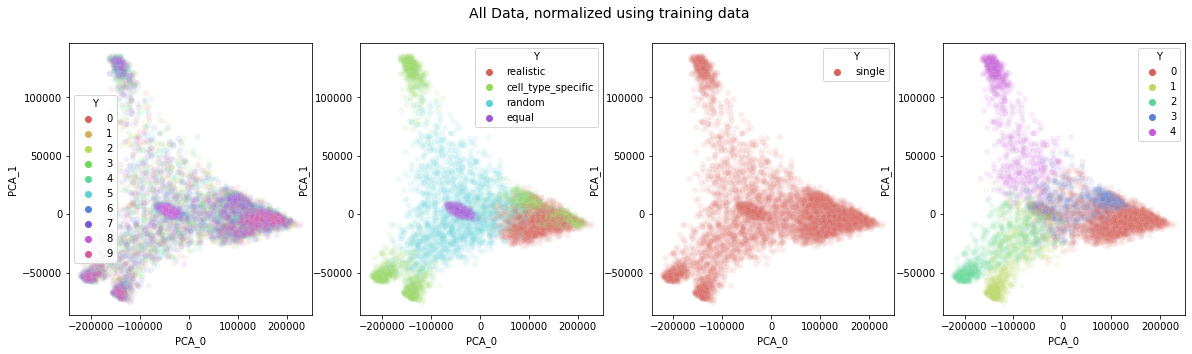

In [14]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

In [15]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == bulkprop_type)[0]
pseudo_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudo_df.index = range(0,len(pseudo_df))
prop_df.index = pseudo_df.index
meta_df.index = meta_df.index
pseudo_df.columns = sn_adata.var_names
pseudo_df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,63.0,205.0,1.0,2914.0,144.0,55.0,210.0,10.0,73.0,0.0,...,0.0,0.0,0.0,1.0,7.0,0.0,0.0,6.0,0.0,0.0
1,84.0,239.0,8.0,3538.0,172.0,37.0,188.0,21.0,65.0,0.0,...,1.0,0.0,0.0,4.0,0.0,0.0,0.0,11.0,0.0,0.0
2,70.0,194.0,1.0,3505.0,391.0,28.0,133.0,7.0,49.0,0.0,...,2.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0
3,65.0,247.0,6.0,3623.0,151.0,56.0,209.0,12.0,32.0,1.0,...,0.0,0.0,0.0,6.0,2.0,0.0,0.0,8.0,0.0,0.0
4,78.0,240.0,7.0,3175.0,143.0,39.0,192.0,14.0,44.0,1.0,...,0.0,0.0,0.0,3.0,0.0,1.0,0.0,9.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,77.0,202.0,3.0,4129.0,355.0,26.0,137.0,11.0,50.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0
1996,62.0,184.0,7.0,4669.0,397.0,29.0,199.0,7.0,39.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
1997,59.0,209.0,5.0,3486.0,85.0,55.0,298.0,11.0,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1998,61.0,242.0,3.0,2254.0,103.0,43.0,185.0,6.0,56.0,0.0,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,6.0,0.0,0.0


In [16]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudo_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudo_df = pseudo_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudo_df

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,74.0,244.0,8.0,4125.0,368.0,28.0,172.0,7.0,36.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0
929,52.0,202.0,2.0,2157.0,192.0,57.0,143.0,17.0,49.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,2.0,0.0,0.0
1506,55.0,200.0,5.0,3605.0,348.0,36.0,142.0,9.0,56.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0
237,54.0,202.0,3.0,1774.0,150.0,38.0,124.0,7.0,84.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0
1371,71.0,251.0,13.0,3647.0,216.0,46.0,172.0,17.0,42.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,73.0,170.0,8.0,4090.0,327.0,26.0,154.0,7.0,32.0,1.0,...,2.0,0.0,0.0,1.0,2.0,0.0,0.0,4.0,0.0,0.0
1132,74.0,242.0,3.0,2848.0,141.0,50.0,220.0,6.0,69.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1998,61.0,242.0,3.0,2254.0,103.0,43.0,185.0,6.0,56.0,0.0,...,1.0,0.0,0.0,2.0,1.0,0.0,0.0,6.0,0.0,0.0
1988,65.0,185.0,1.0,2685.0,174.0,55.0,195.0,7.0,58.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0


In [17]:
#clippign before scaling to 95th pecentile
pseudo_copy = pseudo_df.copy() #keeping genes
pseudo_df = pseudo_df.values #np array
clip_upper = np.quantile(pseudo_df, 0.95)
pseudo_df = np.clip(pseudo_df, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(pseudo_df)
normalized_pseudo_df = scaler.transform(pseudo_df)
normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_pseudo_df      

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,0.493671,0.555556,0.421053,1.000000,0.533225,0.310811,0.248201,0.21875,0.177778,0.0,...,0.333333,0.0,0.0,0.222222,0.000000,0.0,0.0,0.052632,0.000000,0.0
929,0.215190,0.333333,0.105263,0.869648,0.247974,0.702703,0.143885,0.53125,0.322222,0.0,...,0.000000,0.0,0.0,0.000000,0.545455,0.0,0.0,0.105263,0.000000,0.0
1506,0.253165,0.322751,0.263158,1.000000,0.500810,0.418919,0.140288,0.28125,0.400000,0.0,...,0.166667,0.0,0.0,0.000000,0.090909,0.0,0.0,0.157895,0.000000,0.0
237,0.240506,0.333333,0.157895,0.505233,0.179903,0.445946,0.075540,0.21875,0.711111,0.0,...,0.000000,0.0,0.0,0.000000,0.272727,0.0,0.0,0.210526,0.000000,0.0
1371,0.455696,0.592593,0.684211,1.000000,0.286872,0.554054,0.248201,0.53125,0.244444,0.0,...,0.333333,0.0,0.0,0.222222,0.000000,0.0,0.0,0.210526,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.481013,0.164021,0.421053,1.000000,0.466775,0.283784,0.183453,0.21875,0.133333,0.2,...,0.333333,0.0,0.0,0.111111,0.181818,0.0,0.0,0.210526,0.000000,0.0
1132,0.493671,0.544974,0.157895,1.000000,0.165316,0.608108,0.420863,0.18750,0.544444,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.5,0.0,0.052632,0.166667,0.0
1998,0.329114,0.544974,0.157895,0.961941,0.103728,0.513514,0.294964,0.18750,0.400000,0.0,...,0.166667,0.0,0.0,0.222222,0.090909,0.0,0.0,0.315789,0.000000,0.0
1988,0.379747,0.243386,0.052632,1.000000,0.218801,0.675676,0.330935,0.21875,0.422222,0.0,...,0.000000,0.0,0.0,0.000000,0.181818,0.0,0.0,0.157895,0.000000,0.0


In [18]:
# read in cibersort genes 
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()
#and set intersection of gene_ids and cibersort:
gene_notin = np.setdiff1d(gene_ids, cibersort_genes)
#keep genes in both and check number
gene_ids = [ele for ele in gene_ids if ele not in gene_notin]
len(gene_ids)     

2757

In [19]:
#cutting to cibersort genes 
pseudo_copy  = pseudo_copy[gene_ids]
ref_raw = ref_raw.loc[gene_ids,:]
ref_df = ref_df.loc[gene_ids,:]
normalized_pseudo_df = normalized_pseudo_df[gene_ids]
normalized_pseudo_df

,AAGAB,AASS,AATBC,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,...,NMNAT3,NMRK1,NMT2,NMUR1,NNMT,NOC3L,NOCT,NOD2,NOL4L,NOL7
1059,0.523810,0.275229,0.267352,0.265714,0.342604,0.433938,0.244224,0.426648,0.623188,0.415560,...,0.278431,0.504773,0.571979,0.391304,0.390374,0.097451,0.444073,0.331162,0.705837,0.514881
929,0.619048,0.477064,0.749357,0.602857,0.814159,0.300518,0.094059,0.342310,0.152174,0.783681,...,0.366667,0.140811,0.291774,0.463768,0.352941,0.000000,0.824708,0.786102,0.907393,0.208333
1506,0.350140,0.605505,0.273779,0.291429,0.402023,0.489637,0.161716,0.402551,0.509058,0.332068,...,0.268627,0.334129,0.484576,0.405797,0.304813,0.335832,0.287145,0.297503,0.572763,0.351190
237,0.285714,0.201835,0.393316,0.334286,0.557522,0.740933,0.143564,0.164422,0.219203,0.358634,...,0.413725,0.201671,0.194087,0.202899,0.465241,0.668666,0.482471,0.436482,0.411673,0.535714
1371,0.605042,0.192661,0.341902,0.394286,0.608091,0.284974,0.280528,0.738483,0.402174,0.605313,...,0.488235,0.461814,0.370180,0.289855,0.427807,0.170915,0.647746,0.451683,0.629572,0.482143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.386555,0.321101,0.167095,0.185714,0.376738,0.319948,0.171617,0.630758,0.612319,0.305503,...,0.313725,0.523866,0.541131,0.362319,0.245989,0.203898,0.337229,0.250814,0.535409,0.392857
1132,0.610644,0.587156,0.287918,0.342857,0.701643,0.462435,0.429043,1.000000,0.226449,0.462998,...,0.574510,0.471360,0.215938,0.304348,0.347594,0.505247,0.495826,0.371336,0.361868,0.354167
1998,0.588235,0.174312,0.465296,0.571429,0.673831,0.457254,0.232673,0.549965,0.152174,0.637571,...,0.431373,0.181384,0.186375,0.246377,0.379679,0.278861,0.632721,0.571118,0.463813,0.369048
1988,0.512605,0.311927,0.520566,0.467143,0.667509,0.235751,0.075908,0.924876,0.228261,0.660342,...,0.421569,0.261337,0.214653,0.362319,0.181818,0.163418,0.666110,0.637351,0.670817,0.110119


TSNEs of Pseuboulks and References:

===> Finding 180 nearest neighbors using Annoy approximate search using euclidean distance...


   --> Time elapsed: 0.83 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 500 iterations...


Iteration   50, KL divergence 0.7924, 50 iterations in 0.2971 sec


Iteration  100, KL divergence 0.7773, 50 iterations in 0.2425 sec


Iteration  150, KL divergence 0.7699, 50 iterations in 0.2700 sec


Iteration  200, KL divergence 0.7690, 50 iterations in 0.2449 sec


Iteration  250, KL divergence 0.7691, 50 iterations in 0.2755 sec


Iteration  300, KL divergence 0.7684, 50 iterations in 0.2434 sec


Iteration  350, KL divergence 0.7680, 50 iterations in 0.2412 sec


Iteration  400, KL divergence 0.7680, 50 iterations in 0.2376 sec


Iteration  450, KL divergence 0.7680, 50 iterations in 0.2379 sec


Iteration  500, KL divergence 0.7682, 50 iterations in 0.2338 sec
   --> Time elapsed: 2.53 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...


   --> Time elapsed: 0.61 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 9001.0674, 50 iterations in 0.0432 sec
Iteration  100, KL divergence 8972.4786, 50 iterations in 0.0402 sec
Iteration  150, KL divergence 8965.2752, 50 iterations in 0.0366 sec
Iteration  200, KL divergence 8961.8984, 50 iterations in 0.0357 sec


Perplexity value 60 is too high. Using perplexity 1.33 instead


Iteration  250, KL divergence 8958.9170, 50 iterations in 0.0377 sec
   --> Time elapsed: 0.19 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 20.1251, 50 iterations in 0.0203 sec
Iteration  100, KL divergence 20.0213, 50 iterations in 0.0196 sec
Iteration  150, KL divergence 19.8218, 50 iterations in 0.0181 sec
Iteration  200, KL divergence 19.4858, 50 iterations in 0.0234 sec
Iteration  250, KL divergence 19.4492, 50 iterations in 0.0213 sec
   --> Time elapsed: 0.10 seconds
===> Finding 4 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity ma

Iteration   50, KL divergence 0.0311, 50 iterations in 0.2051 sec


Iteration  100, KL divergence 0.0339, 50 iterations in 0.2044 sec


Iteration  150, KL divergence 0.0332, 50 iterations in 0.2091 sec


Iteration  200, KL divergence 0.0321, 50 iterations in 0.2093 sec


Iteration  250, KL divergence 0.0319, 50 iterations in 0.2089 sec


Iteration  300, KL divergence 0.0318, 50 iterations in 0.2165 sec


Iteration  350, KL divergence 0.0319, 50 iterations in 0.2083 sec


Iteration  400, KL divergence 0.0320, 50 iterations in 0.2109 sec


Iteration  450, KL divergence 0.0320, 50 iterations in 0.2134 sec


Iteration  500, KL divergence 0.0322, 50 iterations in 0.2119 sec
   --> Time elapsed: 2.10 seconds
===> Finding 5 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 16.3992, 50 iterations in 0.0177 sec
Iteration  100, KL divergence 16.1436, 50 iterations in 0.0170 sec
Iteration  150, KL divergence 16.1407, 50 iterations in 0.0186 sec
Iteration  200, KL divergence 16.1327, 50 iterations in 0.0193 sec
Iteration  250, KL divergence 16.1130, 50 iterations in 0.0196 sec
   --> Time elapsed: 0.09 seconds
===> Finding 5 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time

Iteration  150, KL divergence 8607.1040, 50 iterations in 0.0334 sec
Iteration  200, KL divergence 8605.4863, 50 iterations in 0.0317 sec
Iteration  250, KL divergence 8601.5570, 50 iterations in 0.0364 sec
   --> Time elapsed: 0.17 seconds


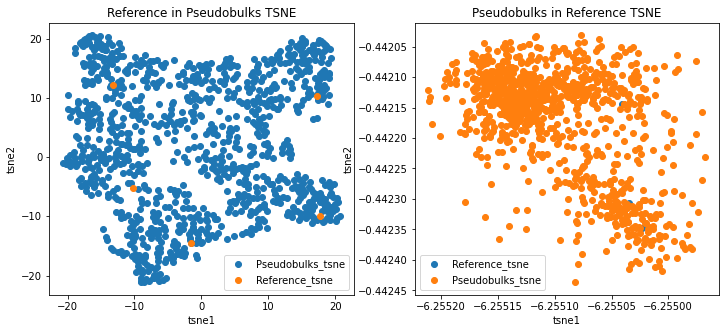

In [20]:
#tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
#figures
plt.figure(figsize=(12, 5))
#data used
x_train = normalized_pseudo_df.values
x_test = ref_df.T.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 1)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
plt.title(f"Reference in Pseudobulks TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
#data used (switching)
x_train = ref_df.T.values
x_test = normalized_pseudo_df.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 2)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Pseudobulks_tsne" )
plt.title(f"Pseudobulks in Reference TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
plt.show()

In [21]:
# Putting together all reference expression, scaled and unscaled, and props.
all_refs = dict()
all_prop_refs = dict()
all_prop_refs_rebalanced = dict()
all_refs_raw = dict()
all_refs_av = dict()
#with no cell missing is just ref_df
all_refs[0] = ref_df
all_refs_raw[0] = ref_raw
all_prop_refs[0] = prop_df
all_prop_refs_rebalanced[0] = prop_df
#assigning the rest in a loop
for num in num_missing_cells[1:]:
    #dropping cell types missing from references
    all_refs[num] = ref_df.drop(ref_df.columns[cells_to_miss[num]], axis=1)
    all_refs_raw[num] = ref_raw.drop(ref_raw.columns[cells_to_miss[num]], axis=1)
    all_prop_refs[num] = prop_df.drop(prop_df.columns[cells_to_miss[num]], axis=1) 
    all_prop_refs_rebalanced[num] = all_prop_refs[num]
    for idx,sample in all_prop_refs_rebalanced[num].iterrows():
        tot = np.sum(sample) #making them equal 1
        sample = sample / tot

## NNLS Deconvolution:

In [22]:
calc_prop_tot, calc_res_tot, custom_res_tot, comparison_prop_tot, missing_cell_tot  = vp.calc_nnls(all_refs, prop_df, normalized_pseudo_df, num_missing_cells, cells_to_miss)

Exp 0


Exp 1


Exp 2


Exp 3


Evalutating NNLS Performance:

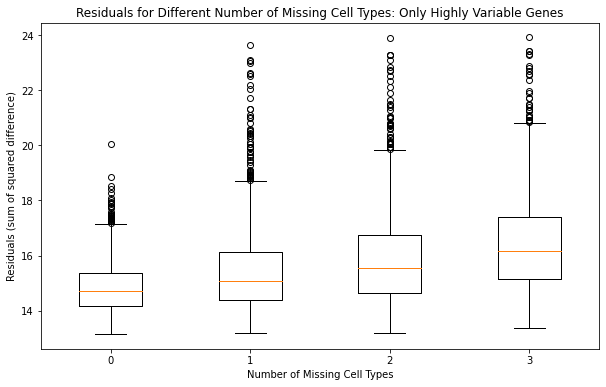

In [23]:
#Distribution of residuals as the sum of squared difference from NNLS
residuals = [calc_res_tot[exp] for exp in num_missing_cells]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=num_missing_cells)
plt.xlabel('Number of Missing Cell Types')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Different Number of Missing Cell Types: Only Highly Variable Genes')
## nnls(A, b)
## /Ax -b/^2
plt.show()

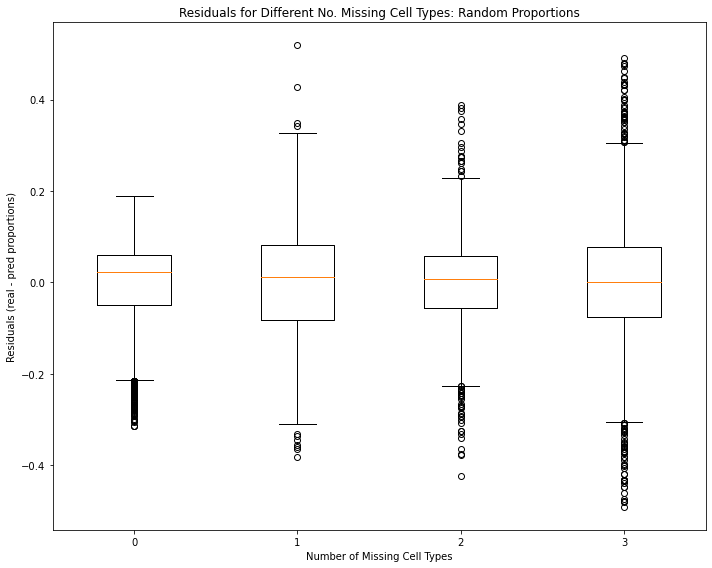

In [24]:
#Distribution of residuals as the difference between calculated and real proportions.
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

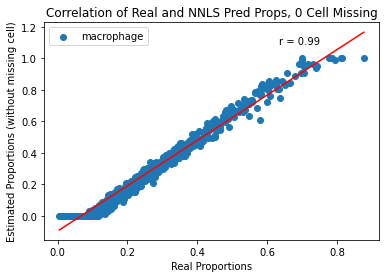

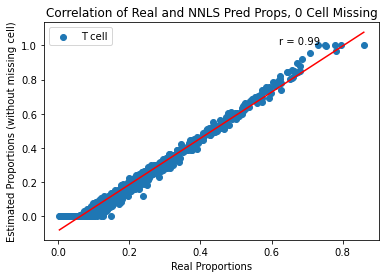

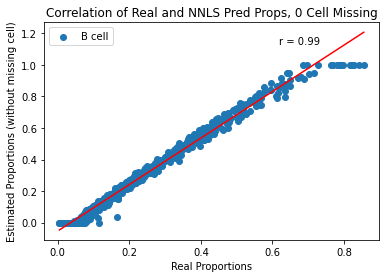

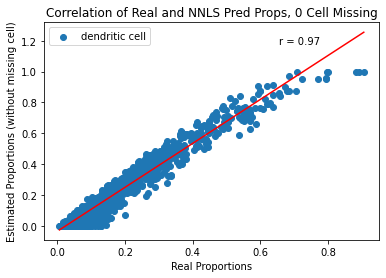

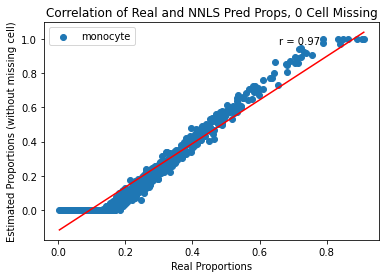

In [25]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in all_prop_refs[num].columns:
    x = all_prop_refs_rebalanced[num][col_cell].values.astype(float)
    y = calc_prop_tot[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 5)
Estimated Proportions shape: (1000, 5)


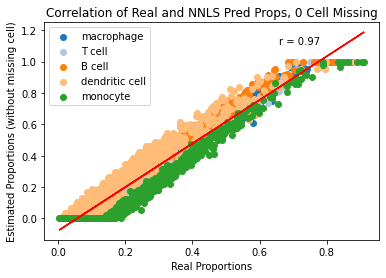

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


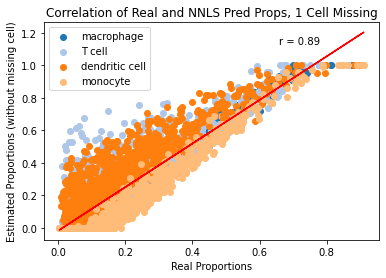

Real Proportions shape: (1000, 3)
Estimated Proportions shape: (1000, 3)


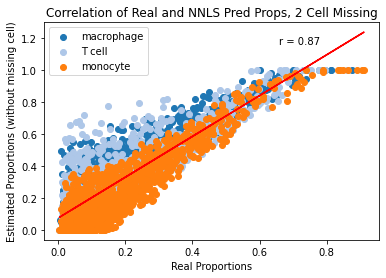

Real Proportions shape: (1000, 2)
Estimated Proportions shape: (1000, 2)


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


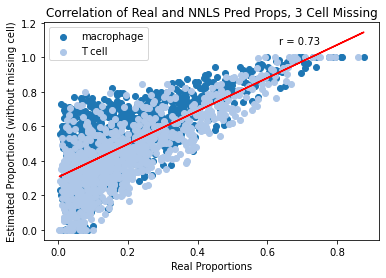

In [26]:
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
for num in num_missing_cells:
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float) #real proportions of present cells
    estimated_proportions = calc_prop_tot[num].values.astype(float) #estimated proportions of present cells.
    cell_types = all_prop_refs[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        color = cmap(i)  #unique color for each cell type
        ax.scatter(x, y, label=cell_type, color=color)
    #fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='best')  #show the cell type labels in the legend
    plt.show()

Recreate Matrices:

In [27]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(all_refs[num] @ calc_prop_tot[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids
recreated_mat_all[0]    

,AAGAB,AASS,AATBC,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,...,NMNAT3,NMRK1,NMT2,NMUR1,NNMT,NOC3L,NOCT,NOD2,NOL4L,NOL7
0,0.421501,0.049515,0.068925,0.589727,0.317859,0.345228,0.302074,0.523121,0.196787,0.311398,...,0.143822,0.335816,0.468648,0.018762,0.121373,0.210656,0.171888,0.153962,0.607605,0.282827
1,0.467286,0.047459,0.340859,0.777454,0.544855,0.307932,0.244573,0.462881,0.054630,0.407564,...,0.181734,0.142645,0.263954,0.006455,0.096323,0.191289,0.312114,0.426295,0.758742,0.234704
2,0.400237,0.059594,0.074660,0.591664,0.335308,0.415352,0.278038,0.431656,0.172182,0.269985,...,0.152433,0.256212,0.403605,0.015910,0.124135,0.304478,0.158037,0.144392,0.509103,0.278530
3,0.389732,0.071980,0.115324,0.628891,0.410830,0.516571,0.264921,0.421877,0.089297,0.251752,...,0.203725,0.145792,0.258542,0.007630,0.134825,0.428040,0.184971,0.189316,0.345769,0.278516
4,0.448071,0.048875,0.121521,0.645168,0.403413,0.365495,0.330847,0.697010,0.113440,0.366727,...,0.209454,0.321782,0.367984,0.011238,0.133282,0.218191,0.243558,0.245206,0.543912,0.292040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.410815,0.053844,0.025660,0.565044,0.299906,0.388350,0.314537,0.554548,0.193184,0.290113,...,0.159219,0.343433,0.457596,0.018063,0.131938,0.255241,0.156776,0.116559,0.513447,0.294969
996,0.420140,0.073864,0.071832,0.625102,0.437613,0.434941,0.347101,0.665872,0.075379,0.293484,...,0.250229,0.283018,0.277076,0.007487,0.132417,0.359403,0.201828,0.174269,0.292756,0.286347
997,0.436607,0.057992,0.173852,0.680077,0.460498,0.425999,0.299742,0.607227,0.063759,0.345689,...,0.226185,0.214401,0.269287,0.006247,0.132156,0.303500,0.256330,0.284592,0.474021,0.280356
998,0.456679,0.055880,0.254029,0.727690,0.509570,0.307459,0.282862,0.521458,0.076255,0.374084,...,0.193303,0.213214,0.294307,0.008564,0.098714,0.214097,0.269677,0.337502,0.646608,0.243652


## **Extracting Missing Cell Information:**

In [28]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = prop_df[missing_cell_tot[num].columns]  

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))



In [29]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = normalized_pseudo_df.values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids)
residuals[0]    

,AAGAB,AASS,AATBC,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,...,NMNAT3,NMRK1,NMT2,NMUR1,NNMT,NOC3L,NOCT,NOD2,NOL4L,NOL7
0,0.102309,0.225715,0.198427,-0.324012,0.024746,0.088710,-0.057850,-0.096473,0.426401,0.104161,...,0.134610,0.168957,0.103331,0.372542,0.269001,-0.113205,0.272185,0.177200,0.098231,0.232054
1,0.151761,0.429605,0.408499,-0.174596,0.269304,-0.007414,-0.150513,-0.120570,0.097544,0.376117,...,0.184933,-0.001833,0.027820,0.457313,0.256618,-0.191289,0.512594,0.359807,0.148651,-0.026371
2,-0.050097,0.545911,0.199119,-0.300235,0.066715,0.074286,-0.116321,-0.029104,0.336876,0.062083,...,0.116195,0.077917,0.080970,0.389887,0.180678,0.031354,0.129108,0.153111,0.063660,0.072660
3,-0.104018,0.129854,0.277992,-0.294605,0.146692,0.224362,-0.121356,-0.257455,0.129906,0.106882,...,0.210000,0.055879,-0.064454,0.195269,0.330415,0.240625,0.297499,0.247166,0.065904,0.257198
4,0.156971,0.143785,0.220382,-0.250882,0.204678,-0.080521,-0.050319,0.041473,0.288734,0.238586,...,0.278782,0.140031,0.002196,0.278617,0.294526,-0.047277,0.404188,0.206477,0.085660,0.190103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.024260,0.267257,0.141435,-0.379330,0.076832,-0.068402,-0.142920,0.076210,0.419135,0.015390,...,0.154506,0.180433,0.083535,0.344256,0.114051,-0.051343,0.180453,0.134255,0.021961,0.097888
996,0.190504,0.513292,0.216086,-0.282245,0.264030,0.027495,0.081942,0.334128,0.151070,0.169514,...,0.324280,0.188342,-0.061138,0.296861,0.215177,0.145844,0.293998,0.197066,0.069112,0.067819
997,0.151628,0.116320,0.291444,-0.108649,0.213333,0.031255,-0.067069,-0.057262,0.088415,0.291883,...,0.205188,-0.033017,-0.082912,0.240130,0.247523,-0.024640,0.376392,0.286526,-0.010208,0.088692
998,0.055926,0.256047,0.266537,-0.260548,0.157940,-0.071708,-0.206954,0.403418,0.152006,0.286257,...,0.228265,0.048122,-0.079654,0.353755,0.083104,-0.050679,0.396433,0.299849,0.024209,-0.133533


## **Singular Value Decomposition**

SVD on each residual matrix. For this purposes, we will only focus on U and S.

U: Left singular vectors, representing the column space of the original matrix. (cells)

Σ or sigma: Singular values, representing the diagonal matrix of singular values.

Vh or V^T: Right singular vectors, representing the row space of the original matrix. (sample)

Calculating SVD

In [30]:
num_cells_missing = num_missing_cells #for each number of missing cells
num_celltypes = len(sn_adata.obs['cell_types'].unique())

In [31]:
# SVD on pseudobulk for QC
df = normalized_pseudo_df
Mat_pseudo = df.astype("float32")
U_pseudo, s_pseudo, V_pseudo = sp.linalg.svd(Mat_pseudo)
U_pseudo = pd.DataFrame(U_pseudo)
s_pseudo = pd.DataFrame(s_pseudo)
V_pseudo = pd.DataFrame(V_pseudo)

In [32]:
# SVD on residual 1
U_all = dict()
s_all = dict()
V_all = dict()
Matres_all = dict()

for num in num_cells_missing:
    df = residuals[num]
    Mat = df.astype("float32")
    U, s, V = sp.linalg.svd(Mat)
    U = pd.DataFrame(U)
    s = pd.DataFrame(s)
    V = pd.DataFrame(V)

    U_all[num] = U
    s_all[num] = s
    V_all[num] = V
    Matres_all[num] = Mat

In [33]:
#SVD on reference for QC
U_all_ref = dict()
s_all_ref = dict()
V_all_ref = dict()
Matref_all_ref = dict()

for num in num_cells_missing:
    df = all_refs[num]
    Mat_ref  = df.astype("float32")
    U_ref , s_ref , V_ref  = sp.linalg.svd(Mat_ref )
    U_ref = pd.DataFrame(U_ref )
    s_ref  = pd.DataFrame(s_ref )
    V_ref  = pd.DataFrame(V_ref )

    U_all_ref[num] = U_ref 
    s_all_ref[num] = s_ref 
    V_all_ref[num] = V_ref 
    Matref_all_ref[num] = Mat_ref 

In [34]:
#SVD on recreated matrix for QC
U_all_rec = dict()
s_all_rec = dict()
V_all_rec = dict()
Matres_all_rec = dict()

for num in num_cells_missing:
    df = recreated_mat_all[num]
    Mat_rec = df.astype("float32")
    U_rec , s_rec , V_rec  = sp.linalg.svd(Mat_rec )
    U_rec  = pd.DataFrame(U_rec )
    s_rec  = pd.DataFrame(s_rec )
    V_rec  = pd.DataFrame(V_rec )

    U_all_rec[num] = U_rec 
    s_all_rec[num] = s_rec 
    V_all_rec[num] = V_rec 
    Matres_all_rec[num] = Mat_rec 

S-Value Eval for each SVD:

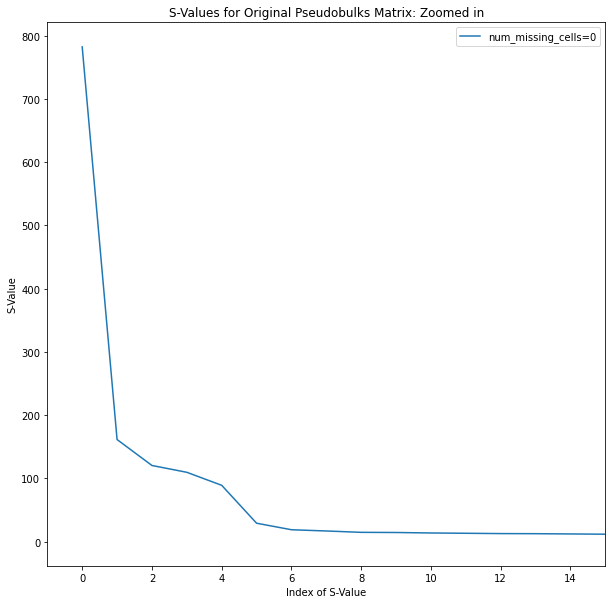

In [35]:
###SVD on Pseudobulk##
num =0
plt.figure(figsize = [10,10])
# Create a color map
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
dataframe = pd.DataFrame(s_pseudo)
x = dataframe.index
y = dataframe.values.flatten()
color = color_map(num_missing_cells.index(num))
label = f"num_missing_cells={num}"
plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Original Pseudobulks Matrix: Zoomed in')
plt.xlim([-1,num_celltypes + 10])
# Add a legend
plt.legend()
# Display the plot
plt.show()

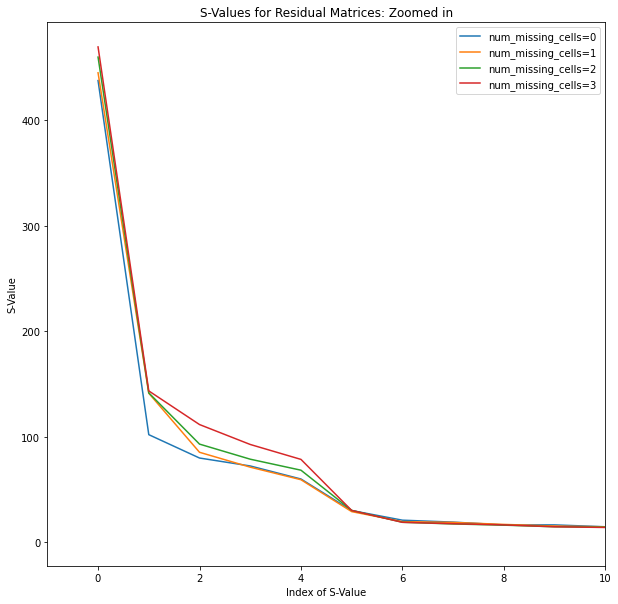

In [36]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating num 
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)
# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Residual Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

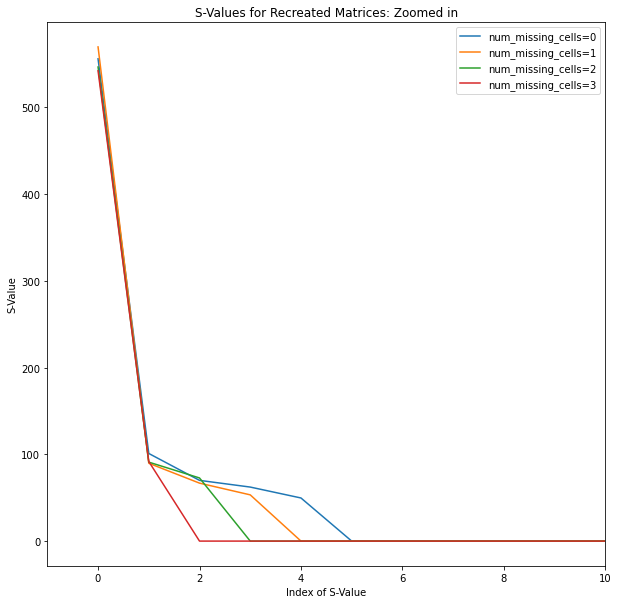

In [37]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_rec[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Recreated Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

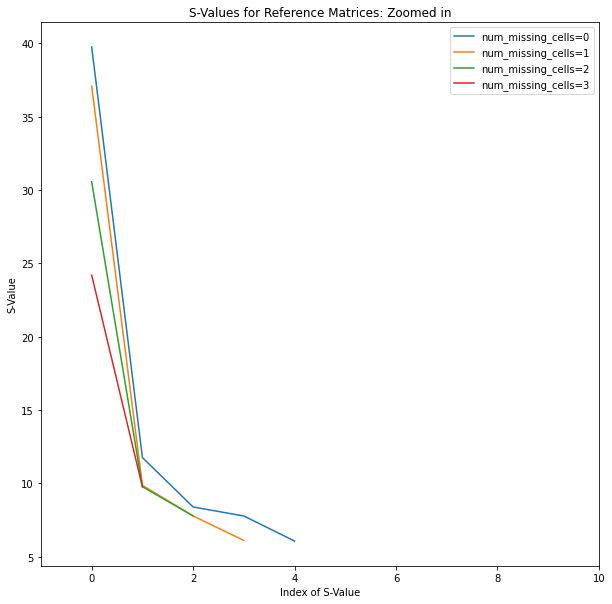

In [38]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_ref[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Reference Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

**Reconstructing Residual Matrix**

In [39]:
#reconstructing SVD using all only some S values, Residual 1.
Recon_Mat_matchS = dict()
for num in num_cells_missing:
    num_SVs = num + 1 #num of comp
    #cutting S and U to 30 to match elbow plots
    U = U_all[num].values[:, :num_SVs]
    S = np.zeros((U.shape[1], Matres_all[num].shape[0]))
    diag_val = s_all[num].values[:num_SVs]
    np.fill_diagonal(S, [diag_val])
    anum = U @ S #reconstructing
    #saving to df dict
    Recon_Mat_matchS[num] = pd.DataFrame(anum[:,0:num_SVs])

**Plotting Correlations between SVD on Residual and Missing Cell Information:**

**Residual** 

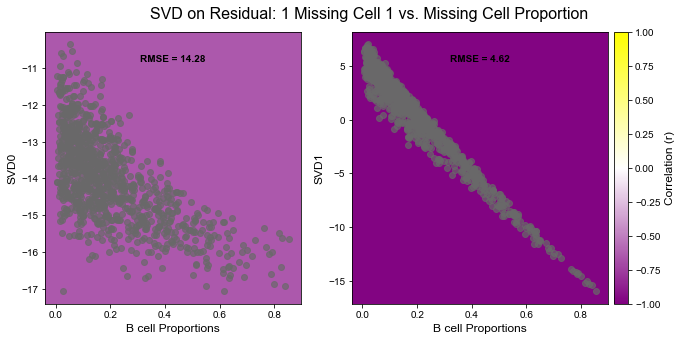

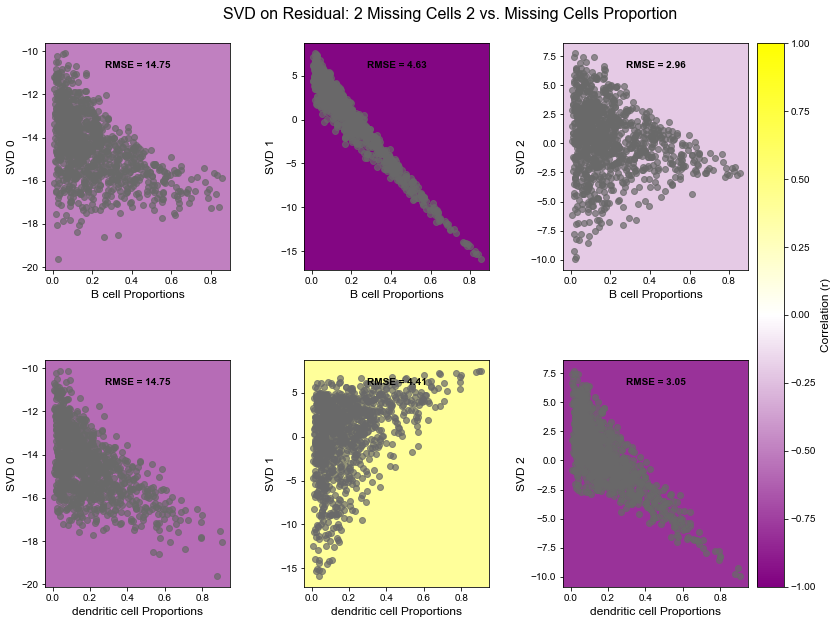

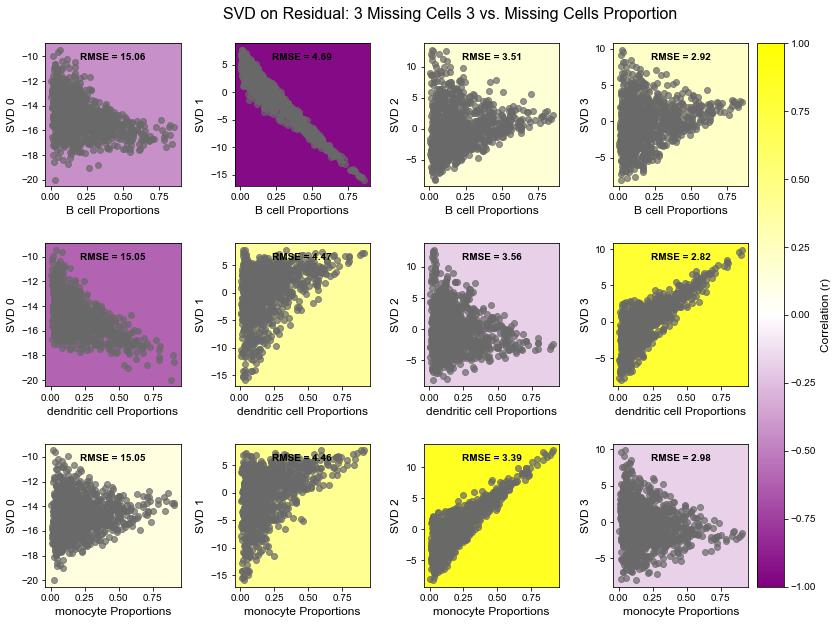

In [40]:
#SVD Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
vp.factors_vs_proportions_rmse(Recon_Mat_matchS, missing_cell_prop, num_missing_cells, "SVD") 
#Each missing cell's expression * proportion matrix is projected into the SVD's reconstructed matrix (just S * U).        

## **PCA**

Calculating PCA for each Residual and Percent of Variance Explained

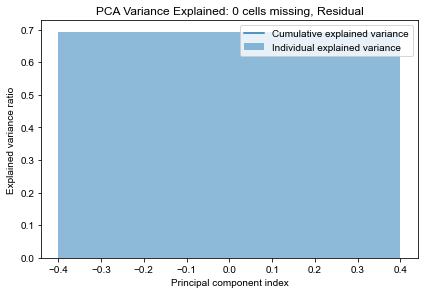

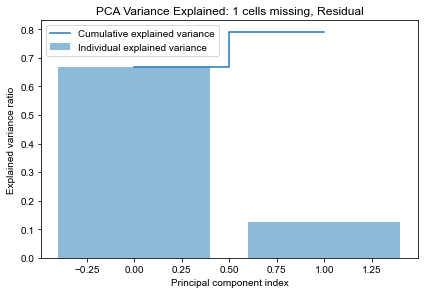

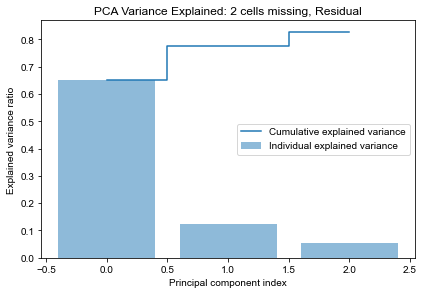

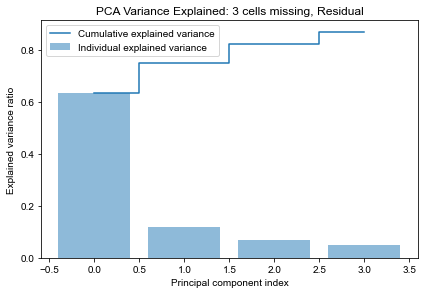

In [41]:
pca_res = dict()
for num in num_cells_missing:
    df = residuals[num].T #transposing to get length of genes instead of samples
    fit = PCA(n_components= num + 1)
    pca_results = fit.fit_transform(df.values)

    exp_var_pca = fit.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    ## plot variance explained
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA Variance Explained: {num} cells missing, Residual")
    plt.show()
    pca_res[num] = pd.DataFrame(pca_results)

Analyzing PCA Results

Residual

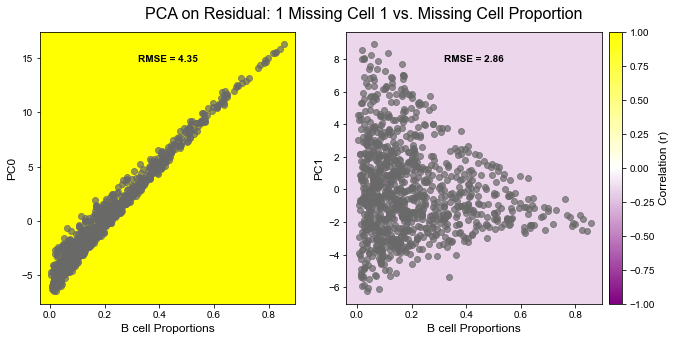

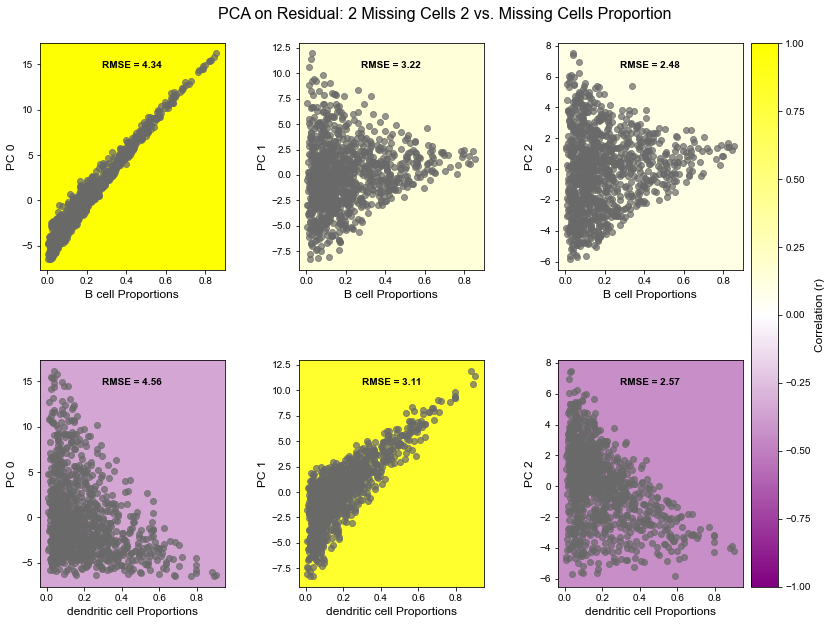

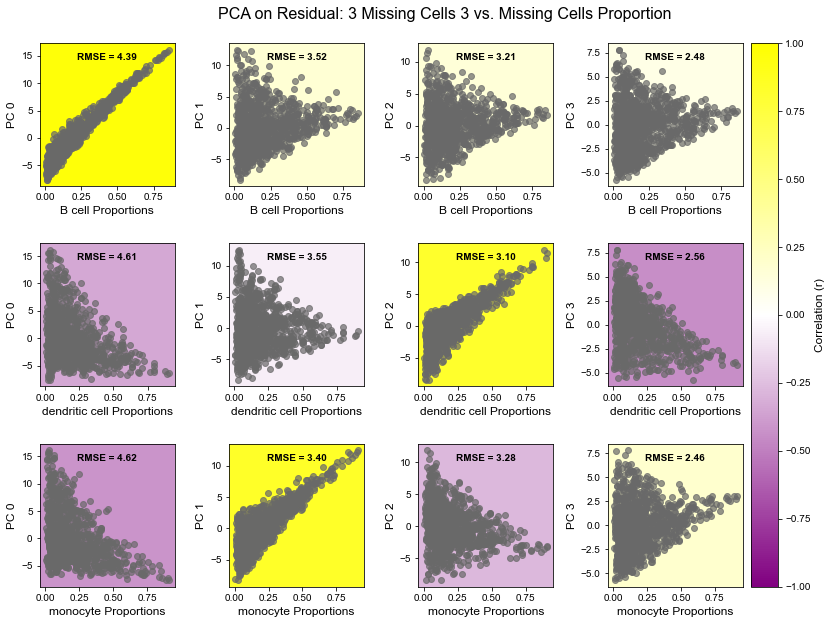

In [42]:
#PCA Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_pca_sample = dict()
for num in num_missing_cells[1:]:
    num_pca = num + 1
    pca = PCA(n_components = num_pca)
    res_pca_df = pca.fit_transform(residuals[num])
    res_pca_sample[num] = pd.DataFrame(res_pca_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_pca_sample, missing_cell_prop, num_cells_missing, "PCA")

## **ICA**

Calculate ICA

In [43]:
#ICA on residual 1
res_ica = dict()
for num in num_missing_cells:
    num_ica = num + 1
    ica = FastICA(n_components = num_ica)
    res_ica_df = ica.fit_transform(residuals[num].T)
    res_ica_df = pd.DataFrame(res_ica_df)
    res_ica[num] = res_ica_df

Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


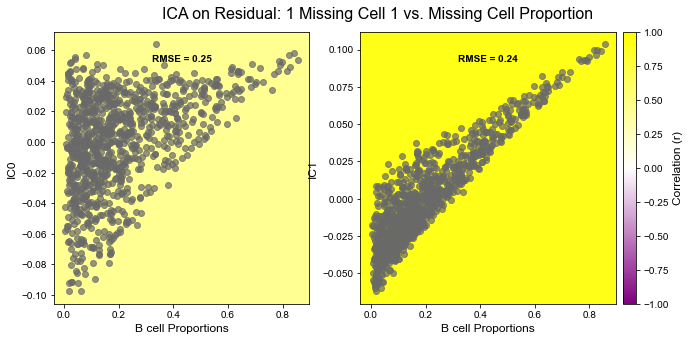

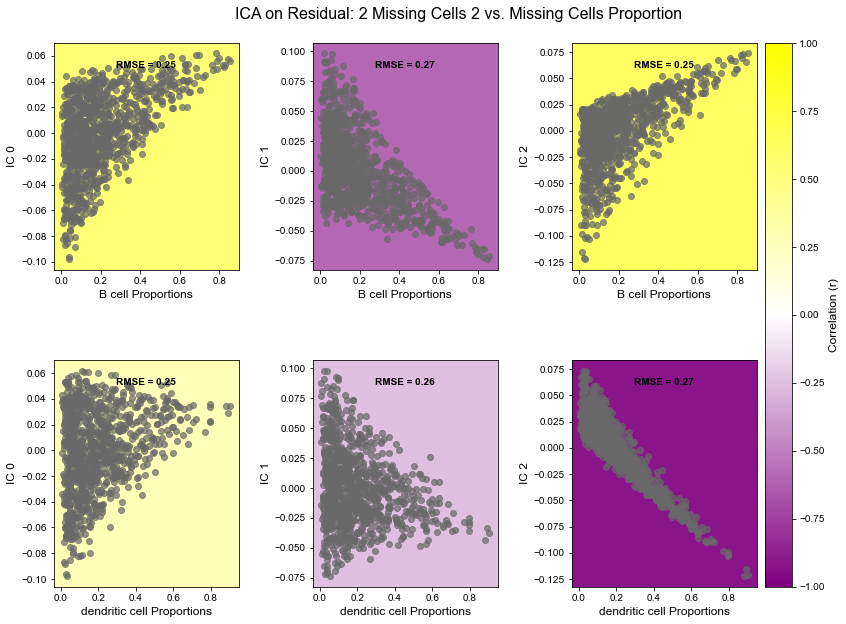

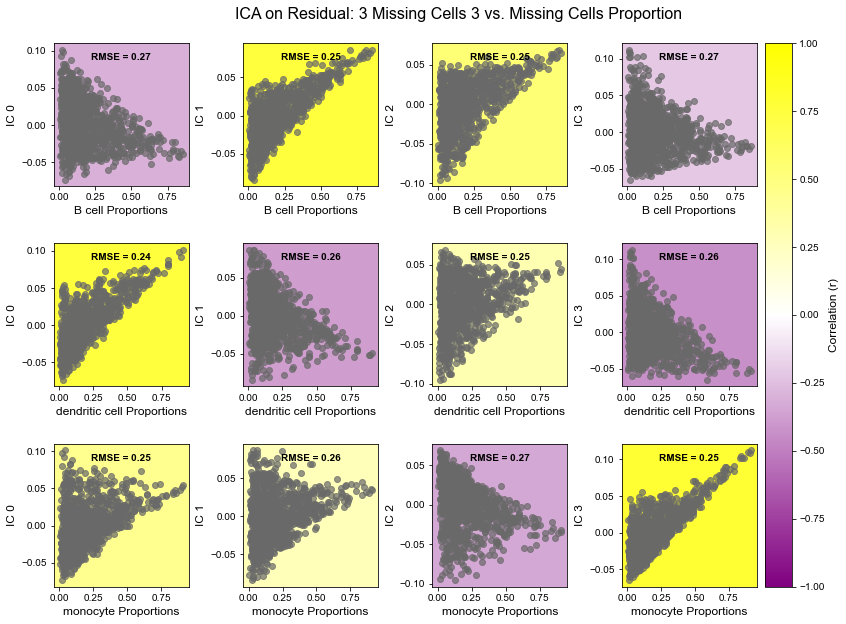

In [44]:
#ICA Residual (by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_ICA_sample = dict()
for num in num_missing_cells[1:]:
    num_ICA = num + 1
    ica = FastICA(n_components = num_ICA)
    res_ICA_df = ica.fit_transform(residuals[num])
    res_ICA_sample[num] = pd.DataFrame(res_ICA_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_rmse(res_ICA_sample, missing_cell_prop, num_cells_missing, "ICA")

## NMF

Analyzing how close to negative the distributions of each residual are:

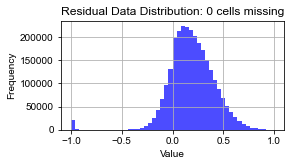

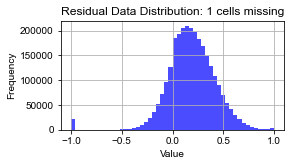

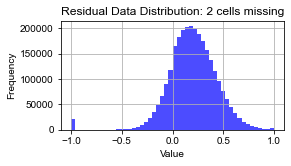

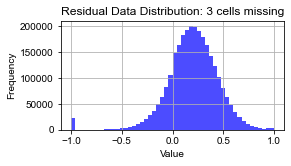

In [45]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000002


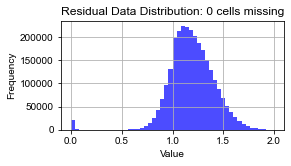

1.0000000000000002


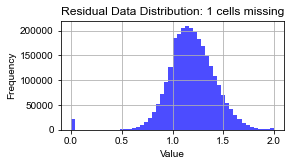

1.0000000000000002


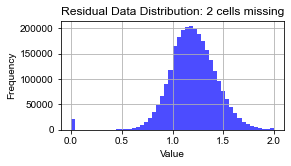

1.0000000000000002


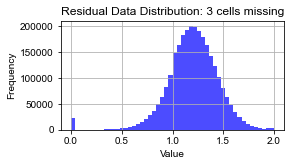

In [46]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Analyzing NMF Results:

Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


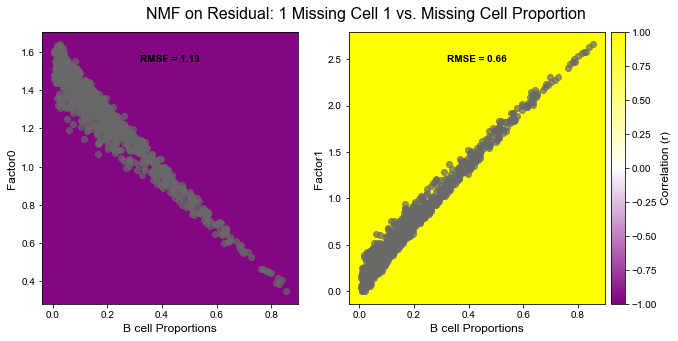

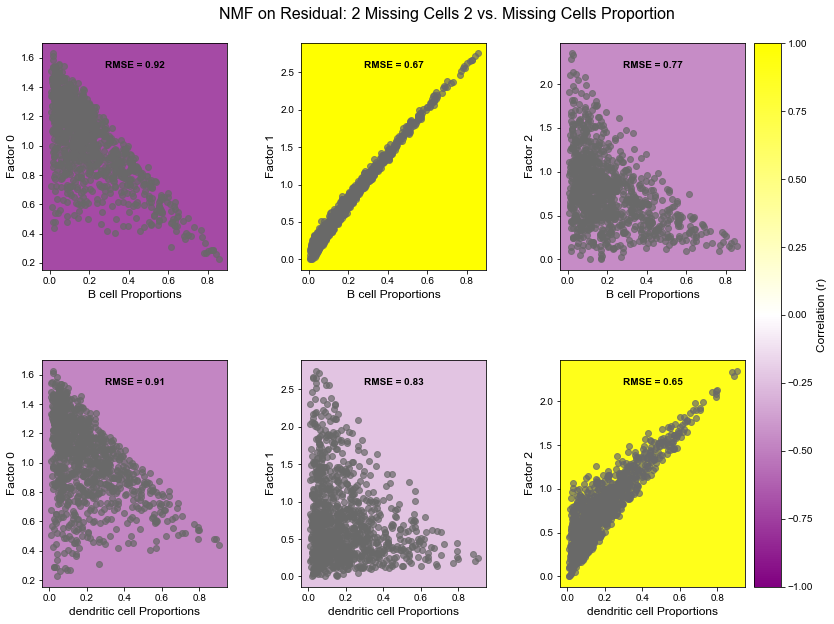

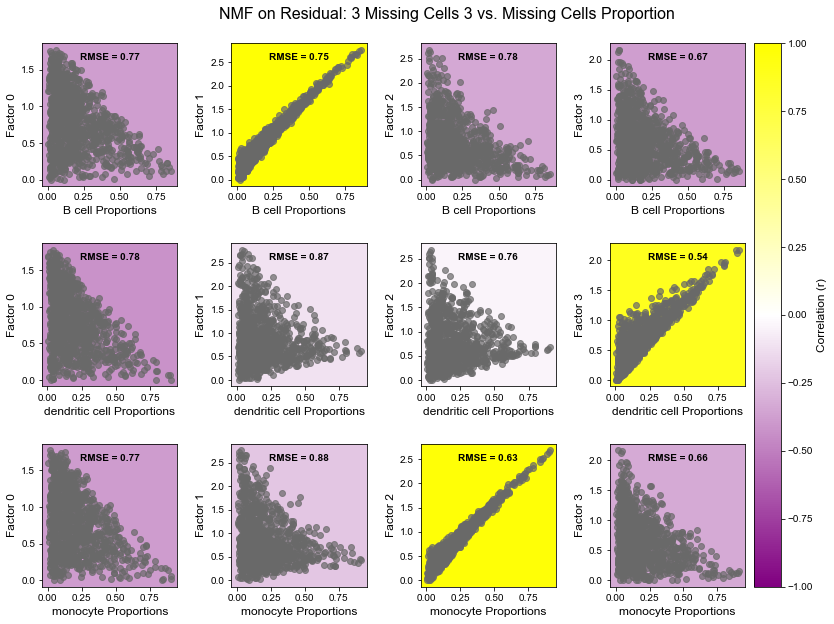

In [47]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000, init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 10000 reached. Increase it to improve convergence.
  warnings.warn(


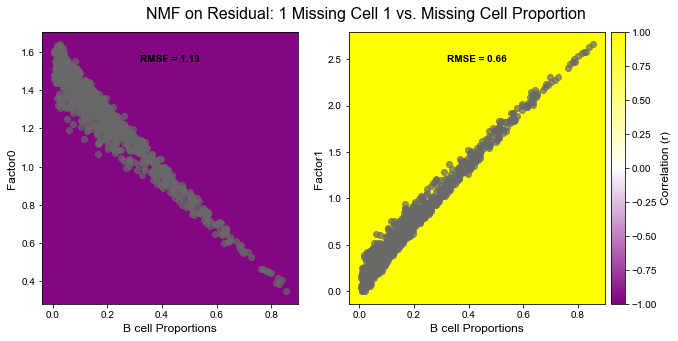

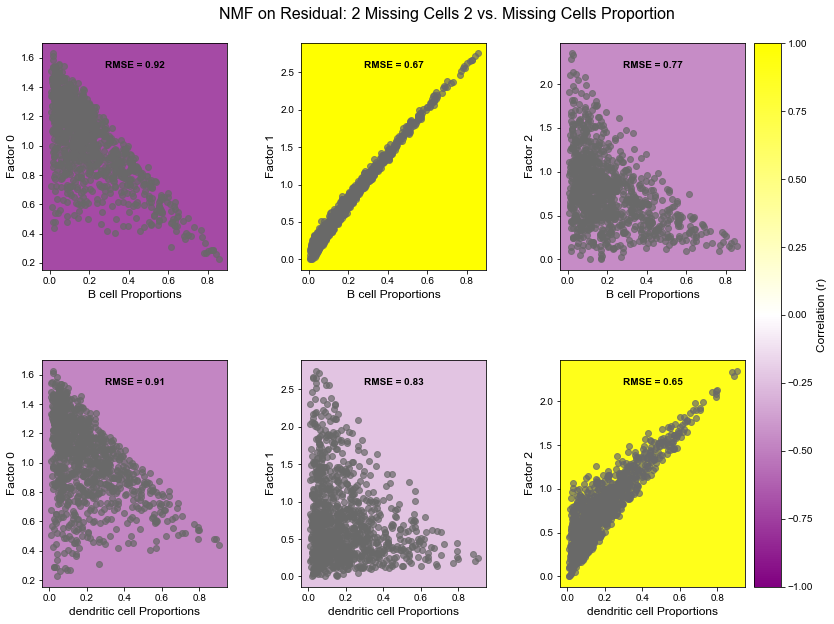

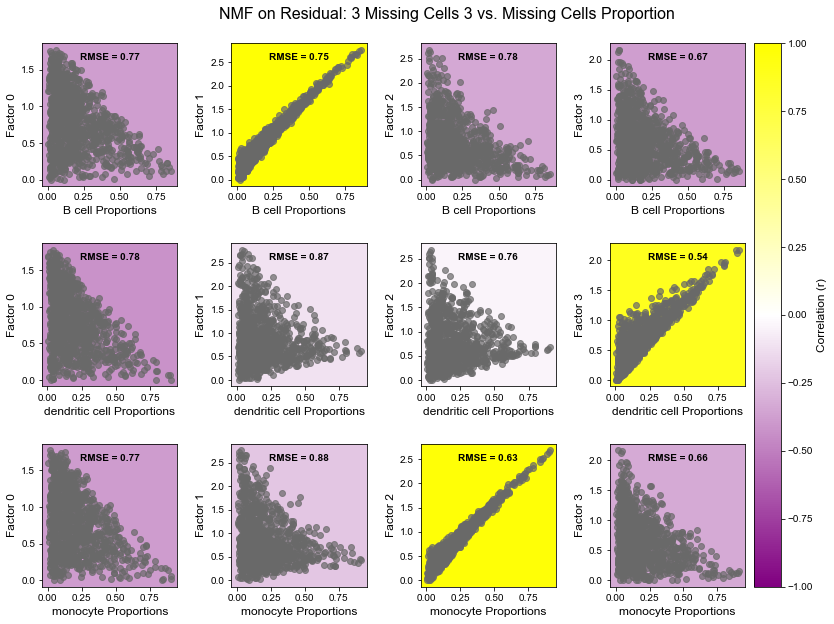

In [48]:
#NMF Residual(by sample) compared to each missing celltype proportion
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 10000 ,init='nndsvd')
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_rmse(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 